In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
dir_path = os.getcwd()


In [2]:
d_types = ['data', 'test']
data = dict()
for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK2/EMGaussian." + d_type 
        data[d_type] = pd.read_csv(path, sep=' ', header=None).values

In [3]:
def computeKMeans(X, niterMax):
    x0min = np.min(X[:, 0])
    x0max = np.max(X[:, 0])
    x1min = np.min(X[:, 1])
    x1max = np.max(X[:, 1])
    oldCenters = [[0,0] for i in range(4)]
    centers = np.random.rand(4,2)
    centers[:,0] = ((x0max - x0min)*centers[:,0])+x0min
    centers[:,1] = ((x1max - x1min)*centers[:,1])+x1min
    clusters = [4 for i in range(len(X))]
    i = 0
    while not np.array_equal(centers,oldCenters) and i < niterMax:
        oldCenters = np.copy(centers)
        i += 1
        for j in range(len(X)):
            minDist = 1000000000
            cluster = 4
            for k in range(len(centers)):
                dist = np.linalg.norm(X[j]-centers[k])
                if dist < minDist:
                    minDist = dist
                    cluster = k
            clusters[j]=cluster
        
        for l in range(len(centers)):
            subset = [clusters[m]==l for m in range(len(clusters))]
            Xsubset = X[subset,:]
            if len(Xsubset) > 0:
                centers[l] = Xsubset.mean(0)
                  
    return centers, clusters
            
        

In [4]:
def plotKMeans(X, centers, clusters):  
    label_color_map = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'purple'
                   }

    fig = plt.figure(figsize=(10,10))
    
    ax = fig.add_subplot(111, aspect='equal')
    label_color = [label_color_map[l] for l in clusters]
    ax.scatter(X[:,0], X[:,1], c=label_color, marker="o", s=50)
        
    ax.scatter(centers[:,0], centers[:,1], color="black", marker = 'v', s=100)
    
    plt.title("K-means")
    plt.show()
    
    
def computeDistortionMeasures(X, centers, clusters):
    measure = 0
    for l in range(len(centers)):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset,:]
        norm = [np.linalg.norm(Xsubset[m]-centers[l]) for m in range(len(Xsubset))]
        measure += sum(norm)
        
    return measure
        
    

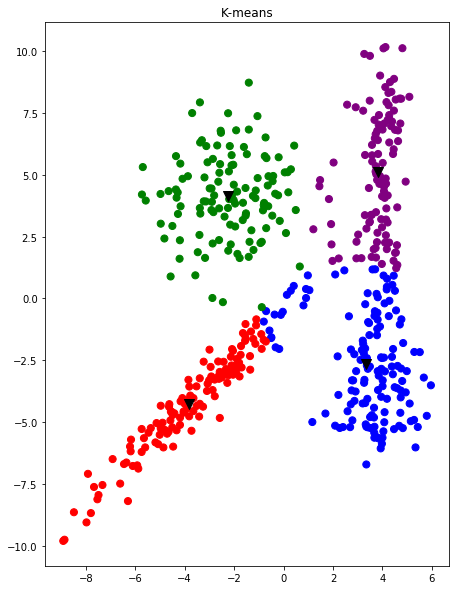

centers :
[ -3.818793543307086 -4.274234409448818 ]
[ -2.240347525 4.127447716666667 ]
[ 3.3355796597222227 -2.644529 ]
[ 3.8028082568807355 5.104672477064219 ]
distortion measure :  1109.4166282170172


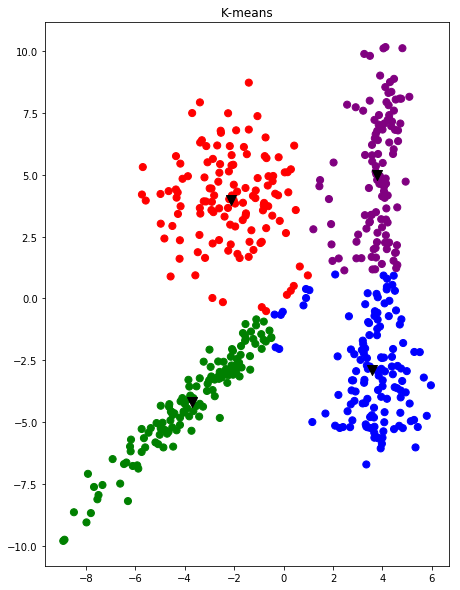

centers :
[ -2.1418000239999997 3.973384288 ]
[ -3.7202048091603044 -4.184997404580152 ]
[ 3.5742918257575766 -2.8808279999999997 ]
[ 3.788092857142859 4.99905357142857 ]
distortion measure :  1103.9226924970349


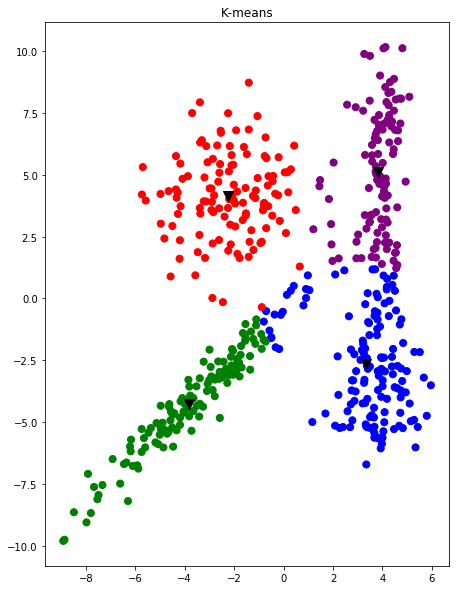

centers :
[ -2.240347525 4.127447716666667 ]
[ -3.818793543307086 -4.274234409448818 ]
[ 3.3355796597222227 -2.644529 ]
[ 3.8028082568807355 5.104672477064219 ]
distortion measure :  1109.4166282170172


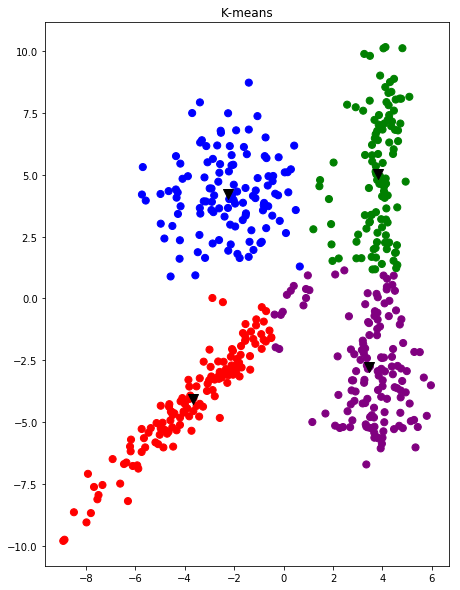

centers :
[ -3.6611894814814807 -4.068399140740739 ]
[ 3.800074774774777 5.033873873873873 ]
[ -2.2447251538461535 4.237431794871796 ]
[ 3.475081832116789 -2.753595299270073 ]
distortion measure :  1105.1446786952404


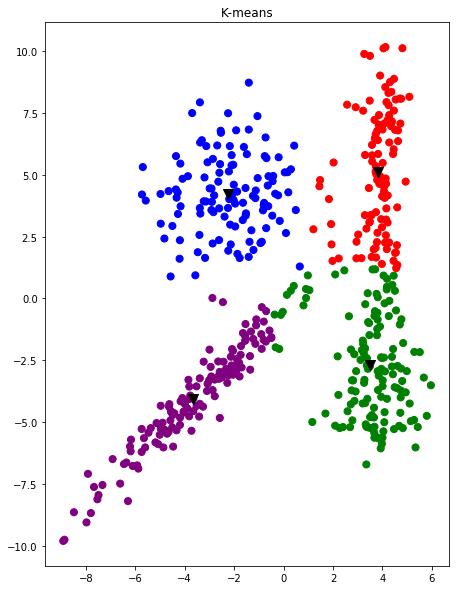

centers :
[ 3.8028082568807355 5.104672477064219 ]
[ 3.4776144676258998 -2.697063712230216 ]
[ -2.2447251538461535 4.237431794871796 ]
[ -3.6611894814814807 -4.068399140740739 ]
distortion measure :  1105.8380512958806


In [5]:
for i in range(5):
    X = data['data']
    centers, clusters = computeKMeans(X, 1000)
    plotKMeans(X, centers, clusters)
    distortionMeasure = computeDistortionMeasures(X, centers, clusters)
    print("centers :")
    for i in range(len(centers)):
        print("[",*centers[i],"]")
    print("distortion measure : ",distortionMeasure)

In [6]:
def getOptimalParametersOfKmeans(X, numTries):
    optimalCenters, optimalClusters = computeKMeans(X, 100)
    measureMax = computeDistortionMeasures(X, optimalCenters, optimalClusters)
    for i in range(1, numTries):
        X = data['data']
        centers, clusters = computeKMeans(X, 100)
        distortionMeasure = computeDistortionMeasures(X, centers, clusters)
        if distortionMeasure < measureMax :
            measureMax = distortionMeasure
            optimalCenters = centers
            optimalClusters = clusters
    return optimalCenters, optimalClusters

### b) Gaussian Mixture with covariance matrix proportionnal to the identity

In [7]:
def computeEMForB(X, niter):
    centers, clusters = getOptimalParametersOfKmeans(X, 10)
    
    # ----------------- init pi
    pi = [0,0,0,0]
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        pi[l]= np.sum(subset)/len(X)
    
    # ----------------- init sigmas
    sigmas = dict()
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset, :]
        sigma = (np.sum((Xsubset - centers[l])**2))/len(Xsubset)
        sigmas[l] = sigma * np.identity(2)
    
        
    # ----------------- init q
    q = np.zeros((len(X), 4))
    
    for i in range(niter):
        # E step
        n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0])
        n1 = scipy.stats.multivariate_normal(centers[1], sigmas[1])
        n2 = scipy.stats.multivariate_normal(centers[2], sigmas[2])
        n3 = scipy.stats.multivariate_normal(centers[3], sigmas[3])
        for x in range(len(X)):
            n0x = n0.pdf(X[x])
            n1x = n1.pdf(X[x])
            n2x = n2.pdf(X[x])
            n3x = n3.pdf(X[x])
            tot = n0x+n1x+n2x+n3x
            q[x,0] = n0x/tot
            q[x,1] = n1x/tot
            q[x,2] = n2x/tot
            q[x,3] = n3x/tot

        # M step
        for l in range(4):
            sumq = np.sum(q[:,l])
            pi[l] = sumq/(np.sum(q[:,0])+np.sum(q[:,1])+np.sum(q[:,2])+np.sum(q[:,3]))
            centers[l] = ([q[k,l]*X[k] for k in range(len(X))]/sumq).sum(0)

            Xcentered = [X[k]-centers[l] for k in range(len(X))]
            Xcenteredsquare = [x**2 for x in Xcentered]
            Xcenteredsquareq = [Xcenteredsquare[k]*q[k,l] for k in range(len(Xcenteredsquare))]
            sigma = 0.5*np.sum(Xcenteredsquareq)/sumq # here d = 2
            sigmas[l] = sigma * np.identity(2)
        
    return pi, centers, sigmas, q
            
        
        

In [8]:
# see https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
def plot_cov_ellipse(cov, pos, color, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_clip_box(ax.bbox)
    ellip.set_alpha(0.3)
    ellip.set_facecolor(color)
    return ellip

In [9]:
def plotEM(X, centers, sigmas, q, title):
    x0 = X[:, 0]
    x1 = X[:, 1]
     
    label_color_map = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'purple'
                   }

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
        
    ax.scatter(centers[:,0], centers[:,1], color="black", marker = 'v', s = 100)
    for i in range(4):
        ell = plot_cov_ellipse(sigmas[i], centers[i, :], label_color_map[i], 2, ax) # 2std => 95%
        
    
    clusters = np.argmax(q,1)
    label_color = [label_color_map[l] for l in clusters]
    ax.scatter(X[:,0], X[:,1], c=label_color, marker="o", s=50)
    
    plt.title(title)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-11, 11)
    plt.show()
    

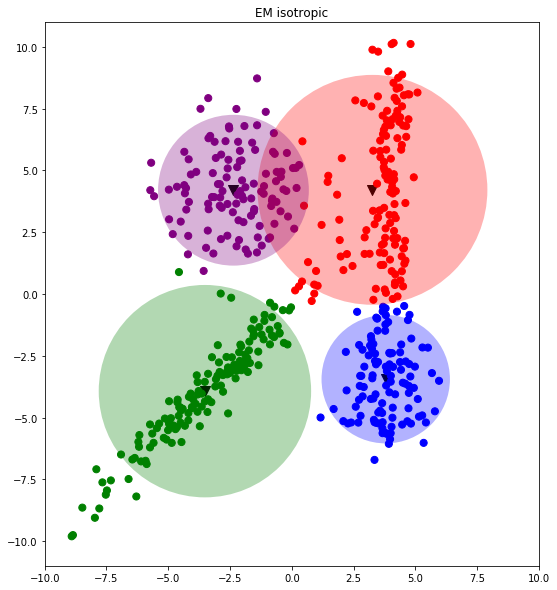

for gaussian 0
	 pi :
	 0.21105411772181137
	 center :
	 [ -2.361352947868629 4.199877540157423 ]
	 cov matrice :
	 [ 2.3276047162433793 0.0 ]
	 [ 0.0 2.3276047162433793 ]
for gaussian 1
	 pi :
	 0.21651591223127534
	 center :
	 [ 3.8017183331202102 -3.4477028680957824 ]
	 cov matrice :
	 [ 1.6879437190116042 0.0 ]
	 [ 0.0 1.6879437190116042 ]
for gaussian 2
	 pi :
	 0.2819082773413743
	 center :
	 [ -3.5154638193949435 -3.9321686912042306 ]
	 cov matrice :
	 [ 4.619014016580243 0.0 ]
	 [ 0.0 4.619014016580243 ]
for gaussian 3
	 pi :
	 0.290521692705539
	 center :
	 [ 3.264063576977094 4.215582435026502 ]
	 cov matrice :
	 [ 5.410227951729157 0.0 ]
	 [ 0.0 5.410227951729157 ]


In [10]:
X = data['data']
pi, centers, sigmas, q = computeEMForB(X, 100)
sort = np.argsort(pi)
plotEM(X, centers, sigmas, q, "EM isotropic")
i = 0
for key in sort:
    print("for gaussian", i)
    i+=1
    print("\t pi :")
    print("\t", pi[key])
    print("\t center :")
    print("\t [",*centers[key],"]")
    print("\t cov matrice :")
    print("\t [",*sigmas[key][0],"]")
    print("\t [",*sigmas[key][1],"]")

### c) Gaussian Mixture with general covariance matrix

In [11]:
def computeEMForC(X, niter):
    centers, clusters = getOptimalParametersOfKmeans(X, 10)
    
    # ----------------- init pi
    pi = [0,0,0,0]
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        pi[l]= np.sum(subset)/len(X)
    
    # ----------------- init cov matrices
    sigmas = dict()
    for l in range(4):
        sigmas[l] = np.zeros((2,2))
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset, :]
        var = (((Xsubset - centers[l])**2)/len(Xsubset)).sum(0)
        sigmas[l][0,0] = var[0]
        sigmas[l][1,1] = var[1]
        
    # ----------------- init q
    q = np.zeros((len(X), 4))
    
    n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0]*np.identity(2))
    
    for i in range(niter):
        # E step
        n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0])
        n1 = scipy.stats.multivariate_normal(centers[1], sigmas[1])
        n2 = scipy.stats.multivariate_normal(centers[2], sigmas[2])
        n3 = scipy.stats.multivariate_normal(centers[3], sigmas[3])
        for x in range(len(X)):
            n0x = n0.pdf(X[x])
            n1x = n1.pdf(X[x])
            n2x = n2.pdf(X[x])
            n3x = n3.pdf(X[x])
            tot = n0x+n1x+n2x+n3x
            q[x,0] = n0x/tot
            q[x,1] = n1x/tot
            q[x,2] = n2x/tot
            q[x,3] = n3x/tot

        # M step
        for l in range(4):
            sumq = np.sum(q[:,l])
            pi[l] = sumq/(np.sum(q[:,0])+np.sum(q[:,1])+np.sum(q[:,2])+np.sum(q[:,3]))
            centers[l] = ([q[k,l]*X[k] for k in range(len(X))]/sumq).sum(0)

            Xcentered = [X[k]-centers[l] for k in range(len(X))]
            tmpSigma = np.zeros((2,2))
            for k in range(len(Xcentered)):
                tmpX = np.dot(Xcentered[k].reshape(2,1), Xcentered[k].reshape(1,2))
                tmpX = tmpX * q[k,l]
                tmpSigma += tmpX
            tmpSigma = tmpSigma / sumq
            sigmas[l] = tmpSigma
        
    return pi, centers, sigmas, q
            
        
            

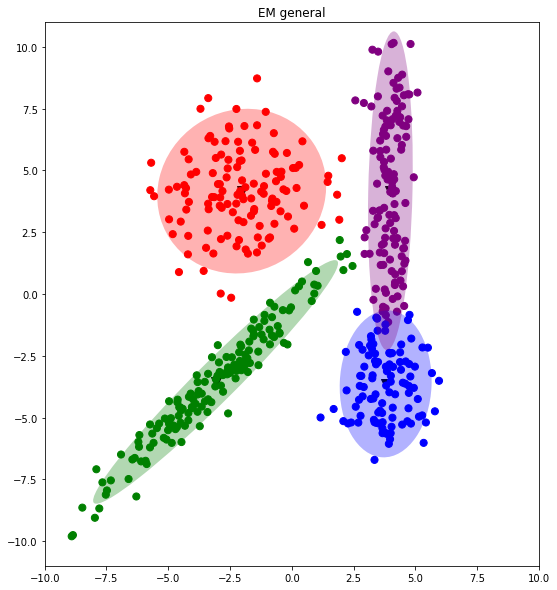

for gaussian 0
	 pi :
	 0.2001992027047367
	 center :
	 [ 3.7992229978835903 -3.637261757229 ]
	 cov matrice :
	 [ 0.8652816275386486 0.05614456442323247 ]
	 [ 0.05614456442323247 2.210190840010049 ]
for gaussian 1
	 pi :
	 0.24338186311420607
	 center :
	 [ 3.9896765762966417 4.177612734889697 ]
	 cov matrice :
	 [ 0.2053987815988766 0.2240126231815721 ]
	 [ 0.2240126231815721 10.403973828165242 ]
for gaussian 2
	 pi :
	 0.25219577018576816
	 center :
	 [ -2.0269935347490153 4.163297110799415 ]
	 cov matrice :
	 [ 2.921508030736941 0.17934072668773313 ]
	 [ 0.17934072668773313 2.7762363107366648 ]
for gaussian 3
	 pi :
	 0.3042231639952891
	 center :
	 [ -3.084626921416505 -3.557973739134528 ]
	 cov matrice :
	 [ 6.141134500978831 5.9472155686295824 ]
	 [ 5.9472155686295824 6.076035333249872 ]


In [12]:
X = data['data']
pi, centers, sigmas, q = computeEMForC(X, 100)
sort = np.argsort(pi)
plotEM(X, centers, sigmas, q, "EM general")
i = 0
for key in sort:
    print("for gaussian", i)
    i += 1
    print("\t pi :")
    print("\t", pi[key])
    print("\t center :")
    print("\t [",*centers[key],"]")
    print("\t cov matrice :")
    print("\t [",*sigmas[key][0],"]")
    print("\t [",*sigmas[key][1],"]")

### d) Comparison of results

When we compare the 2 plots, we notice that the model with general Covariance seems to better capture the data. Indeed, the isotropic model makes the assumptions that the distribution of the data is the same for both axis, which leads the ellipses to be circles and then lead to what seems to be worse results. 

Let's now compute the log-likelihood for both models on the training and testing data to see if what we assume is actually true

The complete log-likelihood is : 
$$ \tilde{l}(\theta) = \sum_{i, k} z_k^{(i)} log(\mathcal{N}(x^{(i)}, \mu_k, \Sigma_k)) + \sum_{i, k} z_k^{(i)} log(\pi_k) $$

In [13]:
def computeLogLikelihoodForIsotropicModel():
    l = 0
    X = data["data"]
    pi, centers, sigmas, q = computeEMForB(X, 100)
    clusters = np.argmax(q,1)
    
    multiNorm = dict()
    multiNorm[0] = scipy.stats.multivariate_normal(centers[0], sigmas[0])
    multiNorm[1] = scipy.stats.multivariate_normal(centers[1], sigmas[1])
    multiNorm[2] = scipy.stats.multivariate_normal(centers[2], sigmas[2])
    multiNorm[3] = scipy.stats.multivariate_normal(centers[3], sigmas[3])
    for i in range(len(X)):
        z = clusters[i]
        l += np.log(multiNorm[z].pdf(X[i])) + np.log(pi[z])
        
    print("for training data of isotropic model, the error is", l/len(X))
    
    X_test = data['test']
    qTest = np.zeros((len(X), 4))
    for x in range(len(X_test)):
        n0x = multiNorm[0].pdf(X_test[x])
        n1x = multiNorm[1].pdf(X_test[x])
        n2x = multiNorm[2].pdf(X_test[x])
        n3x = multiNorm[3].pdf(X_test[x])
        tot = n0x+n1x+n2x+n3x
        qTest[x,0] = n0x/tot
        qTest[x,1] = n1x/tot
        qTest[x,2] = n2x/tot
        qTest[x,3] = n3x/tot
    clustersTest = np.argmax(qTest,1)
    
    lTest = 0
    for i in range(len(X_test)):
        z = clustersTest[i]
        lTest += np.log(multiNorm[z].pdf(X_test[i])) + np.log(pi[z])
    
    print("for testing data of isotropic model, the error is", lTest/len(X_test))
    
    

In [14]:
computeLogLikelihoodForIsotropicModel()

for training data of isotropic model, the error is -5.350896642440507
for testing data of isotropic model, the error is -5.304172422637121


In [15]:
def computeLogLikelihoodForGeneralModel():
    l = 0
    X = data["data"]
    pi, centers, sigmas, q = computeEMForC(X, 100)
    clusters = np.argmax(q,1)
    
    multiNorm = dict()
    multiNorm[0] = scipy.stats.multivariate_normal(centers[0], sigmas[0])
    multiNorm[1] = scipy.stats.multivariate_normal(centers[1], sigmas[1])
    multiNorm[2] = scipy.stats.multivariate_normal(centers[2], sigmas[2])
    multiNorm[3] = scipy.stats.multivariate_normal(centers[3], sigmas[3])
    for i in range(len(X)):
        z = clusters[i]
        l += np.log(multiNorm[z].pdf(X[i])) + np.log(pi[z])
        
    print("for training data of general model, the error is", l/len(X))
    
    X_test = data['test']
    qTest = np.zeros((len(X), 4))
    for x in range(len(X_test)):
        n0x = multiNorm[0].pdf(X_test[x])
        n1x = multiNorm[1].pdf(X_test[x])
        n2x = multiNorm[2].pdf(X_test[x])
        n3x = multiNorm[3].pdf(X_test[x])
        tot = n0x+n1x+n2x+n3x
        qTest[x,0] = n0x/tot
        qTest[x,1] = n1x/tot
        qTest[x,2] = n2x/tot
        qTest[x,3] = n3x/tot
    clustersTest = np.argmax(qTest,1)
    
    lTest = 0
    for i in range(len(X_test)):
        z = clustersTest[i]
        lTest += np.log(multiNorm[z].pdf(X_test[i])) + np.log(pi[z])
    
    print("for testing data of general model, the error is", lTest/len(X_test))
    

In [16]:
computeLogLikelihoodForGeneralModel()

for training data of general model, the error is -4.6902856957291945
for testing data of general model, the error is -4.850768408338124


We see that the log likelihood is on average higher for the general model. Our assumptions were correct. 
For the General Model, the average is higher for the training data which is expected but surprisingly for the Isotropic this is the opposite.